In [ ]:
!pip install git+https://github.com/awslabs/gluonts.git

In [1]:
%matplotlib inline

import multiprocessing
import matplotlib.dates as mdates
from matplotlib import pyplot as plt
from itertools import islice

In [2]:
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

In [3]:
from model.patch_hom import PatchHoMEstimator

In [4]:
dataset = get_dataset("electricity")

In [5]:
estimator = PatchHoMEstimator(
    prediction_length=dataset.metadata.prediction_length,
    context_length=dataset.metadata.prediction_length*4,
    patch_len=40,
  
    batch_size=128,
    num_batches_per_epoch=100,
    trainer_kwargs=dict(max_epochs=50,),
)

In [6]:
predictor = estimator.train(
    training_data=dataset.train,
    shuffle_buffer_length=1024,
    cache_data=True,
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name  | Type          | Params
----------------------------------------
0 | model | PatchHoMModel | 441 K 
-----------------------------

Training: |                                                                                                   …

Epoch 0, global step 100: 'train_loss' reached 6.24797 (best 6.24797), saving model to '/Users/kashif/Github/HoMM/src/lightning_logs/version_1/checkpoints/epoch=0-step=100.ckpt' as top 1
Epoch 1, global step 200: 'train_loss' reached 5.79605 (best 5.79605), saving model to '/Users/kashif/Github/HoMM/src/lightning_logs/version_1/checkpoints/epoch=1-step=200.ckpt' as top 1
Epoch 2, global step 300: 'train_loss' reached 5.72526 (best 5.72526), saving model to '/Users/kashif/Github/HoMM/src/lightning_logs/version_1/checkpoints/epoch=2-step=300.ckpt' as top 1
Epoch 3, global step 400: 'train_loss' reached 5.64306 (best 5.64306), saving model to '/Users/kashif/Github/HoMM/src/lightning_logs/version_1/checkpoints/epoch=3-step=400.ckpt' as top 1
Epoch 4, global step 500: 'train_loss' reached 5.63253 (best 5.63253), saving model to '/Users/kashif/Github/HoMM/src/lightning_logs/version_1/checkpoints/epoch=4-step=500.ckpt' as top 1
Epoch 5, global step 600: 'train_loss' was not in top 1
Epoch 6, 

In [7]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test, 
    predictor=predictor
)

In [8]:
forecasts = list(forecast_it)
tss = list(ts_it)

In [9]:
evaluator = Evaluator()

In [10]:
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))


Running evaluation: 2247it [00:00, 6781.84it/s]
/Users/kashif/Github/gluon-ts/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in scalar divide
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/Users/kashif/Github/gluon-ts/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in scalar divide
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/Users/kashif/Github/gluon-ts/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in scalar divide
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/Users/kashif/Github/gluon-ts/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in scalar divide
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/Users/kashif/Github/gluon-ts/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in scalar divide
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/Users/kashif/Gi

In [11]:
agg_metrics

{'MSE': 1570613.5011620333,
 'abs_error': 9008200.833661081,
 'abs_target_sum': 128632956.0,
 'abs_target_mean': 2385.272140631954,
 'seasonal_error': 189.49338196116761,
 'MASE': 0.8211859849799825,
 'MAPE': 0.1333950301695208,
 'sMAPE': 0.1211174622972762,
 'MSIS': 7.333538652137364,
 'num_masked_target_values': 0.0,
 'QuantileLoss[0.1]': 4444728.035984406,
 'Coverage[0.1]': 0.07519284972556,
 'QuantileLoss[0.2]': 6566249.63354269,
 'Coverage[0.2]': 0.14890224002373537,
 'QuantileLoss[0.3]': 7917247.383584317,
 'Coverage[0.3]': 0.231234238243584,
 'QuantileLoss[0.4]': 8713079.664019002,
 'Coverage[0.4]': 0.3167185877466251,
 'QuantileLoss[0.5]': 9008200.831724435,
 'Coverage[0.5]': 0.41555407209612816,
 'QuantileLoss[0.6]': 8821367.244932469,
 'Coverage[0.6]': 0.5206200860406468,
 'QuantileLoss[0.7]': 8162062.049934122,
 'Coverage[0.7]': 0.629635810710577,
 'QuantileLoss[0.8]': 6886794.628883319,
 'Coverage[0.8]': 0.7460688325174306,
 'QuantileLoss[0.9]': 4724287.657371928,
 'Coverag

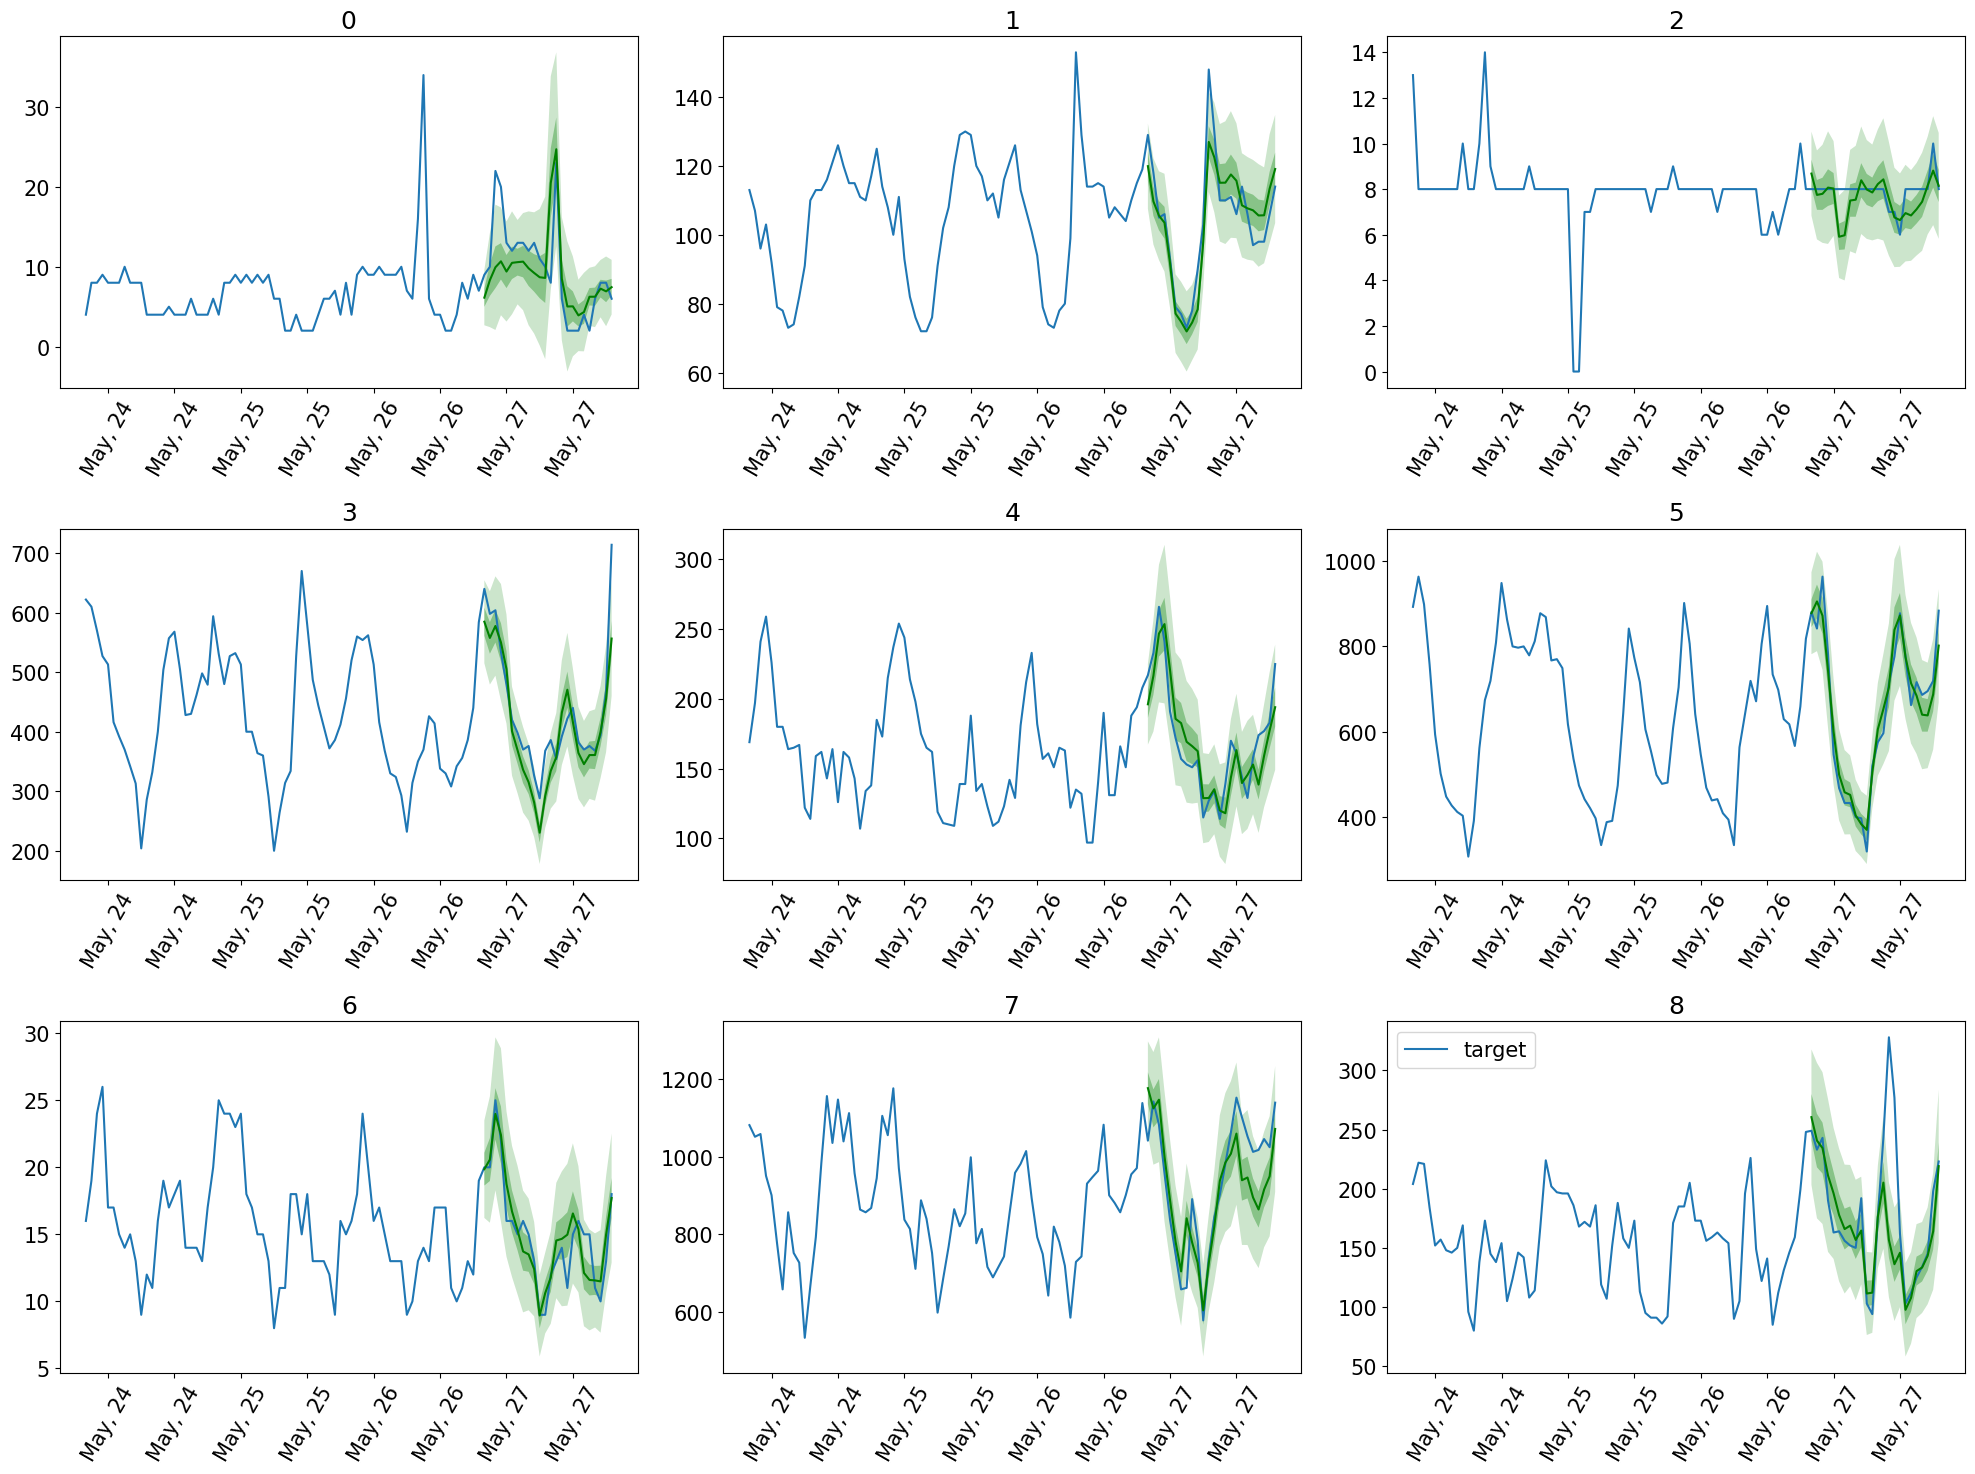

In [12]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    # Convert index for plot
    ts = ts[-4 * dataset.metadata.prediction_length:].to_timestamp()
    
    plt.plot(ts, label="target")
    forecast.plot(color='g')
    plt.xticks(rotation=60)
    plt.title(forecast.item_id)
    ax.xaxis.set_major_formatter(date_formater)

plt.gcf().tight_layout()
plt.legend()
plt.show()